In [3]:
#載入套件
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from cmath import nan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#使用資料夾內鐵達尼號的資料集，練習邏輯迴歸的處理邏輯
training_data = pd.read_csv('data/titanic_data.csv')
print(training_data.head(10))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

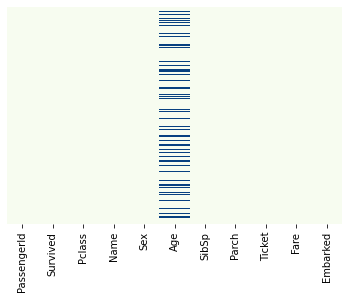

In [5]:
#探索資料
#用heatmap(.isnull()來找出缺失的資料在哪些欄位。Age似乎約有五分之一的資料缺失，可用合理資料補充。)
sns.heatmap(training_data.isnull(), yticklabels=False, cbar=False, cmap="GnBu")
plt.show()

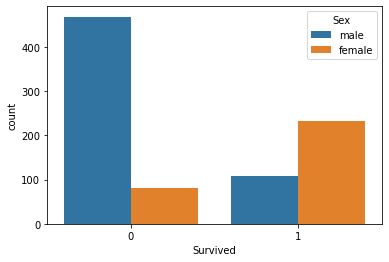

In [6]:
#用countplot來看性別是否影響最後存活。女性存活比例比男性高。
sns.countplot(data=training_data, x="Survived", hue="Sex")
plt.show()

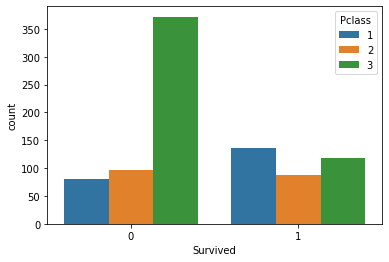

In [7]:
#艙等是否也影響存活?
sns.countplot(data=training_data, x="Survived", hue="Pclass")
plt.show()

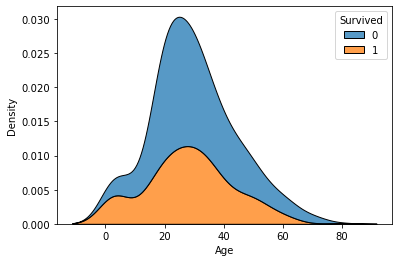

In [8]:
#看年齡分佈。缺失資料在此不計。
sns.kdeplot(data=training_data.dropna(), x="Age",
            hue="Survived", multiple="stack")
plt.show()

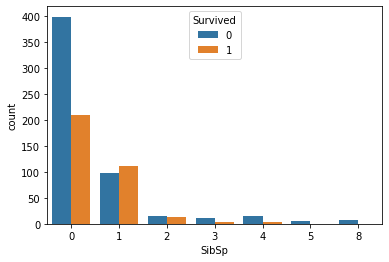

In [9]:
#看兄弟姐妹或眷屬人數分佈(SibSp)
sns.countplot(data=training_data, x="SibSp", hue="Survived")
plt.show()

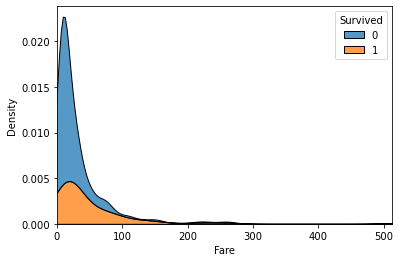

In [10]:
#看票價分佈
sns.kdeplot(data=training_data, x="Fare", hue="Survived", multiple="stack")
plt.xlim(training_data["Fare"].min(), training_data["Fare"].max())
plt.show()

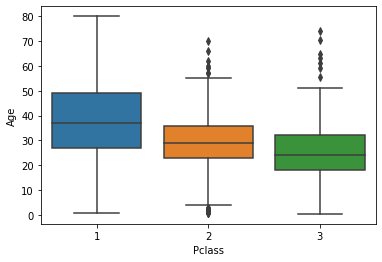

In [11]:
# 使用盒鬚圖來看年齡和艙等的分佈。看起來頭等艙年齡較高，隨之降低。
sns.boxplot(data=training_data, x="Pclass", y="Age")
plt.show()

In [12]:
#資料清理
#剛有看到年齡資料約有五分之一缺失，一種做法是棄之不用，一種可以考慮把年齡平均放進去。
#把艙等平均年齡填入缺失的資料中
#艙等1平均年齡是37，艙等2平均年齡是29，艙等3平均年齡是24

mean_class_1 = training_data.loc[training_data["Pclass"]
                                 == 1]["Age"].dropna().mean()
mean_class_2 = training_data.loc[training_data["Pclass"]
                                 == 2]["Age"].dropna().mean()
mean_class_3 = training_data.loc[training_data["Pclass"]
                                 == 3]["Age"].dropna().mean()
fixed_values = {1: mean_class_1, 2: mean_class_2, 3: mean_class_3}

fixed_age = []
for i_row in range(len(training_data)):
    age = training_data["Age"].loc[i_row]
    pclass = training_data["Pclass"].loc[i_row]
    if pd.isnull(age):
        fixed_age.append(fixed_values[pclass])
    else:
        fixed_age.append(age)
training_data["Age"] = fixed_age

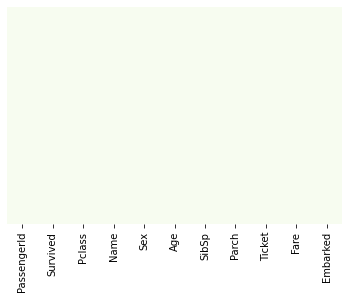

In [13]:
#用heatmap查看年齡是否還有缺失資料
sns.heatmap(training_data.isnull(), yticklabels=False, cbar=False, cmap="GnBu")
plt.show()

In [15]:
#虛擬變數範例
#使用pandas(d.get_dummies)將性別從類別資料轉為數值變數。

#請將drop_first=True，如果為True會刪除第一個類別值。
#本來若有k個level，drop_first=True會只剩下k-1個level，降低共線性的可能
encoded_sex = pd.get_dummies(training_data["Sex"], drop_first=True)
print(encoded_sex.head())

   male
0     1
1     0
2     0
3     0
4     1


In [16]:
#使用pandas將上船的港口從類別資料改換為數值變數(drop_first=True)
encoded_embark = pd.get_dummies(training_data["Embarked"], drop_first=True)
print(encoded_embark.head())

   Q  S
0  0  1
1  0  0
2  0  1
3  0  1
4  0  1


In [17]:
#將原始的性別、登船港口、票號、姓名欄位棄用
#因為PassengerId在此也只是排序，因此也棄用
#將性別及上船港口的數值變數和原始的data結合
training_data.drop(["PassengerId", "Name", "Sex",
                   "Parch", "Ticket", "Embarked"], inplace=True, axis=1)
training_data = pd.concat([training_data, encoded_sex, encoded_embark], axis=1)
print(training_data.head())

   Survived  Pclass   Age  SibSp     Fare  male  Q  S
0         0       3  22.0      1   7.2500     1  0  1
1         1       1  38.0      1  71.2833     0  0  0
2         1       3  26.0      0   7.9250     0  0  1
3         1       1  35.0      1  53.1000     0  0  1
4         0       3  35.0      0   8.0500     1  0  1


In [18]:
#建立feature資料集(選取survived以外所有欄位)與target資料集(survived)
x = training_data.drop(["Survived"], axis=1).values
y = training_data["Survived"].values

In [19]:
#設定隨機種子(random_state)為101，測試組比例佔30%
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state=101)

In [20]:
#建立訓練組邏輯迴歸模型
logmodel = LogisticRegression(solver='newton-cg')
logmodel.fit(x_train, y_train)

LogisticRegression(solver='newton-cg')

In [21]:
#使用模型進行測試集資料的預測
predictions_of_train = logmodel.predict(x_train)
predictions_of_test = logmodel.predict(x_test)

In [22]:
#ground truth
print(y_train)
print(y_test)

[1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0
 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0
 1 1 0 1 1 1 0 1 0 1 0 0 

#### 計算accuracy及結果顯示
accuracy<br>
error_index #錯誤答案是哪幾筆資料<br>
miss classification #錯誤答案<br>
錯誤欄位的正確之原始資料表格

In [23]:
train_error_indices = np.where(predictions_of_train != y_train)[0]
test_error_indices = np.where(predictions_of_test != y_test)[0]

train_accuracy = 100.0*(1.0 - len(train_error_indices)/len(y_train))
test_accuracy = 100.0*(1.0 - len(test_error_indices)/len(y_test))
print(f"Train accuracy = {train_accuracy:^.2f} %")
print(f"Test accuracy = {test_accuracy:^.2f} %")

print("Test error indices:", test_error_indices)
print("Miss classification :", predictions_of_test[test_error_indices])
data_index = training_data.iloc[test_error_indices].index

# 錯誤欄位的正確之原始資料
print(training_data.iloc[data_index])

Train accuracy = 81.70 %
Test accuracy = 78.36 %
Test error indices: [  2   3   6  13  14  33  39  45  55  56  63  67  70  71  74  82  86  89
  94  99 103 104 109 110 111 114 125 127 129 151 155 157 162 164 180 181
 184 192 195 197 198 200 201 205 206 208 210 220 221 230 231 232 235 240
 249 250 262 265]
Miss classification : [1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1
 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0]
     Survived  Pclass        Age  SibSp      Fare  male  Q  S
2           1       3  26.000000      0    7.9250     0  0  1
3           1       1  35.000000      1   53.1000     0  0  1
6           0       1  54.000000      0   51.8625     1  0  1
13          0       3  39.000000      1   31.2750     1  0  1
14          0       3  14.000000      0    7.8542     0  0  1
33          0       2  66.000000      0   10.5000     1  0  1
39          1       3  14.000000      1   11.2417     0  0  0
45          0       3  25.140620      0    8.0500     1  